# Using Machine Learning Classifers with NLTK

## CUNY DATA 620 Web Analytics

### Fall 2018 Semester Class Project


# Instructions

- Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. 


- Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. 


- Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. 


- How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect? 

Source: Natural Language Processing with Python, exercise 6.10.2.

In [186]:
import nltk
import random
import numpy as np
import pandas as pd
from itertools import repeat
from sklearn.model_selection import train_test_split
import re
import math
import pydotplus

from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus


# The Data

Using the NLTK's `names` corpus, we will be demonstrating how to create and improve supervised classification models. The corpus contains 2 files called `female.txt` and `male.txt`.

In [187]:
from nltk.corpus import names
names.fileids() # confirm male and female txt files exist

['female.txt', 'male.txt']

Let's import the male & female names, look at the first 20 entries for each and store them together in a variable called `people`. We will normalize the names by changing them to lowercase letters.

In [188]:
# load male and female  name files from nltk.names; store in people list
males, females = [n.lower() for n in names.words('male.txt')], [n.lower() for n in names.words('female.txt')] 

print([male for male in males[:20]])
print([female for female in females[:20]])

people = males + females

['aamir', 'aaron', 'abbey', 'abbie', 'abbot', 'abbott', 'abby', 'abdel', 'abdul', 'abdulkarim', 'abdullah', 'abe', 'abel', 'abelard', 'abner', 'abraham', 'abram', 'ace', 'adair', 'adam']
['abagael', 'abagail', 'abbe', 'abbey', 'abbi', 'abbie', 'abby', 'abigael', 'abigail', 'abigale', 'abra', 'acacia', 'ada', 'adah', 'adaline', 'adara', 'addie', 'addis', 'adel', 'adela']


We have 7944 names in total.

In [189]:
n_people = len(people)
n_people

7944

Next, let's create the variable `gender`, which will contain the gender labels for each of the names. 

In [190]:
# make gender list
gender = list(repeat('male', len(males))) + list(repeat('female', len(females)))

When we plot the frequency of the male and female names, we see that there is a class imbalance between the two labels. There are considerably more females than males.

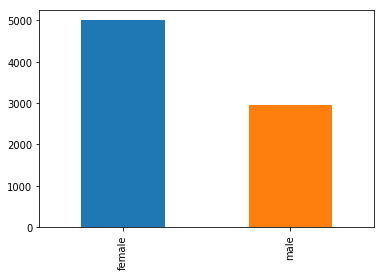

In [191]:
gender_counts = pd.Series(gender).value_counts()
gender_counts.plot.bar()

Specifically, more than 60% are female. We will want to be cognizant of this class imbalance when we choose the metrics to evaluate the strength of our model. If we simply predicted that every name was female, we would be correct more than 60% of the time. We may also want to consider stratifying the training, development and testing data sets.

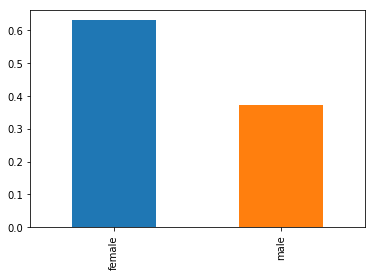

In [192]:
gender_counts.divide(n_people).plot.bar()

# Feature Engineering

Our raw dataset contains only one predictor variable.  This feature indicates the first name of each observed individual in our data.  Unfortunately, the name variable--in its unprocessed form--will not be very useful for building an accurate gender classification model.  A model constructed using first names only will struggle to predict gender for names not explicitly identified in the training data.  Also, our dataset contains a unique collection of first names within each gender class, but has a small number of overlapping names between gender types.  Without additional feature engineering, our models will not be able to make reasonable guesses when encountering gender-neutral names.  

The textbook, *Natural Language Processing with Python*, provides a number of helpful suggestions for extracting new features from first names for gender classification purposes:
* isolate the first letter of each name
* isolate the last letter of each name
* isolate the last two letters of each name.

We decided to include these features as possible predictors for our models.  These extracted features can reveal common patterns in the prefixes and suffixes of first names that are often associated with a particular gender.  For instance, many female first names end with the letter "a".  

Building on the text's suggestions, we also extracted the following features:
* the first two letters of each name
* the first three letters of each name
* the last three letters of each name

There were a handful of additional features that we thought might be relevant for gender identification:
* the number of vowels in each name
* The first two non-contiguous letters of each name 
* The first three non-contiguous letters
* The last two non-contiguous letters
* the last three non-contiguous letters

We also found an [article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4446333/) from an academic journal that characterizes certain letters as "round" and others as "sharp".  The authors contend that round letters tend to be associated with female names, while sharp letters are more often associated with male names.  Using this information, we created the following potential features:
* the number of round, consonant letters ("b","m", "l", and "n") in each name
* the number of sharp, consant letters ("k", "p", and "t") per name
* the number of round vowels ("u" and "o") in each first name.

Finally, we found a Wordpress [blog entry](https://debuk.wordpress.com/tag/feminine-suffixes/) that discusses common female suffixes in first names.  These include names ending in ending in "a", "y", "ie", and "ah".  We used this information to create a new binary variable that identifies if one of these suffixes is present in a given name.

In the script below, we create a function, *gender_features()*, that returns a dictionary of the extracted features described in this section.  The function has multiple arguments:
* a first name to use for extracting features
* a list of desired features.  This argument can be used to vary the features that are returned by the function 

  
   

In [193]:
# produce features
def gender_features(word, *args):
    """
    function returns dictionary of features
        word: name to extract features from
        args:  one or more strings to specify desired features, including:
                'length','first','first2','first3', 'last', 'last2', 'last3',
                'every_other2_beg','every_other3_beg', 'every_other2_end', 'every_other3_end',
                'vowel_ct', 'round_cons_ct', 'sharp_cons_ct','round_vowel_ct',
                trad_female_end'
               
    """
    
    gf = {}
    
    # word length
    gf['length'] = len(word)
   
    # first letters
    gf['first'] = word[0].lower()
    gf['first2'] = word[0:2].lower()
    gf['first3'] = word[0:3].lower() if gf['length'] >2  else word[0:2].lower()
    
    gf['two_letters'] = 'y' if len(word) == 2 else 'n'
    
    # last letters
    gf['last'] = word[-1].lower()
    gf['last2'] = word[-2:].lower()
    gf['last3'] = word[-3:].lower() if gf['length'] >2  else word[-2:].lower()
    
    # every other beg
    gf['every_other2_beg'] = word[0]+word[2] if gf['length'] > 2 else word[0]
    gf['every_other3_beg'] = gf['every_other2_beg']+word[4]  if gf['length'] > 4 else \
    gf['every_other2_beg']
    
    # every other end
    gf['every_other2_end'] = word[-3]+word[-1] if gf['length'] > 2 else word[-1]
    gf['every_other3_end'] = word[-5]+gf['every_other2_end']  if gf['length'] > 4 else \
    gf['every_other2_end']
    
    # count: vowels, rounded consonants, sharp consonants
    for letter in word:
        # count vowels
        if letter in 'aeiou':
            gf['vowel_ct'] = gf.get('vowel_ct',0) + 1
        # count rounded consonants
        if letter in 'bmln':
            gf['round_cons_ct'] = gf.get('round_cons_ct',0) + 1
        # count sharp consonants
        if letter in 'k,p,t':
            gf['sharp_cons_ct'] = gf.get('sharp_cons_ct',0) + 1
        # count rounded vowels
        if letter in 'uo':
            gf['round_vowel_ct'] = gf.get('round_vowel_ct',0) + 1
            
    # traditional feminine ending, 'y' or 'n'
    gf['trad_female_end'] = 'y' if gf['last2'] in ['ie','ah'] or \
    gf['last'] in ['a','y'] else 'n'
    
    ## patterns: double consonant ends in y: Binny, Daffy...
    #gf['consonant_y'] = 'y' if bool(re.search(r"([b-df-hj-np-tv-z])\1{1,}y$", word)) else 'n'
    
    # generate dictionary subset
    return(dict((k, gf[k]) for k in args if k in gf))

In [194]:
# specify which features to use
myargs = ['length','first','first2','first3', 'last', 'last2', 'last3', \
          'every_other2_beg','every_other3_beg', 'every_other2_end', 'every_other3_end', \
          'vowel_ct', 'round_cons_ct', 'sharp_cons_ct','round_vowel_ct', \
          'trad_female_end']

# specify name, and argument list 
gender_features('Binny', *myargs)

{'length': 5,
 'first': 'b',
 'first2': 'bi',
 'first3': 'bin',
 'last': 'y',
 'last2': 'ny',
 'last3': 'nny',
 'every_other2_beg': 'Bn',
 'every_other3_beg': 'Bny',
 'every_other2_end': 'ny',
 'every_other3_end': 'Bny',
 'vowel_ct': 1,
 'round_cons_ct': 2,
 'trad_female_end': 'y'}

# Training, Development & Test Sets

Let's partition our names & labels into 3 buckets. We will stratify each bucket in order to maintain our class imbalance and set the random state to 4.

- First, let's set aside 500 observations that will not be used in training or development. We will use this test set to evaluate the strength of the model.

- Then, let's hold out another 500 observations to use as a development set to do error analysis.

- Finally, we will use the remaining 6944 names to train our model.

In [195]:
# set aside 500 samples for testing
people_dev_train, people_test, gender_dev_train, gender_test = train_test_split(people, 
                                                                        gender, 
                                                                        test_size=500, 
                                                                        stratify=gender, 
                                                                        random_state=4)

# set aside 500 samples for development
people_train, people_devtest, gender_train, gender_devtest = train_test_split(people_dev_train, 
                                                                            gender_dev_train, 
                                                                            test_size=500, 
                                                                            stratify=gender_dev_train,
                                                                            random_state=4)

# list of tuples, gender features, gender
train_set = list(zip(map(gender_features, people_train),gender_train))
devtest_set = list(zip(map(gender_features, people_devtest),gender_devtest))
test_set = list(zip(map(gender_features, people_test),gender_test))

# list of tuples (name, gender)
train_names = list(zip(people_train, gender_train))
devtest_names = list(zip(people_devtest, gender_devtest))
test_names = list(zip(people_test, gender_test))

# Naive Bayes Classification

Let's use the naive Bayes (NB) classifier to build our first model. This model derives its "naiviete" from its independence asssumption. NB assumes that all features are independent of one another, but features within real-world data often contain dependencies. 

## NB Round 1

Since using too many dependent features can cause the NB model to double count the effect of what is essentially the same feature, let's initiate the model with only a handful of features and try the additive approach. We will use the name length, first character and last character.

In [196]:
def create_features(names, genders, features):
    """
    function returns list of tuples (name features, gender)
        names: list of names to extract features from
        genders: list of gender values
        features: list of feature functions           
    """    
    return list(zip(map(lambda d: gender_features(d, *features), names), genders))

initial_NB_features = ['length', 'last', 'first']

train_features  = create_features(people_train, gender_train, initial_NB_features)
devtest_features = create_features(people_devtest, gender_devtest, initial_NB_features)
test_features = create_features(people_test, gender_test, initial_NB_features)

The accuracy between the training and development sets is decent at .78.

In [197]:
# train naive bayes classifier 
nb_classifier = nltk.NaiveBayesClassifier.train(train_features)
# classifer accuracy on validation set
print(nltk.classify.accuracy(nb_classifier, devtest_features))

0.78


Let's take a look at the likelihood ratios of most informative features so far. The last character provides the most information. We should probably try adding more features from the end of the name to see if they improve the model accuracy.

In [198]:
# look at most informative features
nb_classifier.show_most_informative_features(30)

Most Informative Features
                    last = 'a'            female : male   =     34.9 : 1.0
                    last = 'k'              male : female =     30.3 : 1.0
                    last = 'f'              male : female =     15.3 : 1.0
                    last = 'p'              male : female =     11.2 : 1.0
                    last = 'v'              male : female =     11.2 : 1.0
                    last = 'd'              male : female =     10.1 : 1.0
                    last = 'o'              male : female =      8.3 : 1.0
                    last = 'm'              male : female =      8.2 : 1.0
                    last = 'r'              male : female =      6.8 : 1.0
                    last = 'z'              male : female =      6.4 : 1.0
                    last = 'b'              male : female =      6.3 : 1.0
                    last = 'w'              male : female =      5.1 : 1.0
                    last = 'g'              male : female =      4.9 : 1.0

Next, let's take a look at some of the model's misclassified names. From looking at the errors, we see that using only the first and last character is too simplistic. 

In [199]:
# look at names that were mis-classified
errors = []
for (name, tag) in devtest_names:
    #print(name)
    guess = nb_classifier.classify(gender_features(name))
    if guess != tag:
        errors.append((tag, guess, name))

print('actual, guess, name: \n')
for x in errors[:30]:
    print(x)

actual, guess, name: 

('male', 'female', 'wye')
('male', 'female', 'llewellyn')
('male', 'female', 'smith')
('male', 'female', 'garry')
('male', 'female', 'thadeus')
('male', 'female', 'jereme')
('male', 'female', 'harvie')
('male', 'female', 'grant')
('male', 'female', 'gerrit')
('male', 'female', 'woodman')
('male', 'female', 'owen')
('male', 'female', 'roderic')
('male', 'female', 'moses')
('male', 'female', 'arvin')
('male', 'female', 'moishe')
('male', 'female', 'georges')
('male', 'female', 'redmond')
('male', 'female', 'jud')
('male', 'female', 'davin')
('male', 'female', 'abe')
('male', 'female', 'whitaker')
('male', 'female', 'sheffy')
('male', 'female', 'michale')
('male', 'female', 'rufus')
('male', 'female', 'bary')
('male', 'female', 'paten')
('male', 'female', 'jehu')
('male', 'female', 'martyn')
('male', 'female', 'bartolemo')
('male', 'female', 'trace')


## NB Round 2

Since we did some error analysis, let's make sure that we reset our training and development set, so that the model doesn't become biased towards the previous round's idiosyncracies. We will use a different random state.

In [200]:
people_train_v2, people_devtest_v2, gender_train_v2, gender_devtest_v2 = train_test_split(people_dev_train, 
                                                                            gender_dev_train, 
                                                                            test_size=500, 
                                                                            stratify=gender_dev_train,
                                                                            random_state=5)

# list of tuples (name, gender)
train_names_v2 = list(zip(people_train_v2, gender_train_v2))
devtest_names_v2 = list(zip(people_devtest_v2, gender_devtest_v2))

For this 2nd round, let's add some new features from the end characters of the names. We will add the last 2 and the last 3 letters. We will also add the new features to the test set as well.

In [201]:
NB_features_v2 = initial_NB_features + ['last2', 'last3']

train_features_v2  = create_features(people_train_v2, gender_train_v2, NB_features_v2)
devtest_features_v2 = create_features(people_devtest_v2, gender_devtest_v2, NB_features_v2)
test_features_v2 = create_features(people_test, gender_test, NB_features_v2)

Now let's fit the model again using the new features. The accuracy score has improved from .78 to .788.

In [202]:
# train naive bayes classifier 
nb_classifier_v2 = nltk.NaiveBayesClassifier.train(train_features_v2)
# # classifer accuracy on validation set
print(nltk.classify.accuracy(nb_classifier_v2, devtest_features_v2))

0.788


Compared to the 1st round features, the `last2` feature adds a lot of information to the model and `last3` as well to a lesser degree. When the last 2 letters are 'na', the name is 94 times more often female than male.

In [203]:
# # look at most informative features
nb_classifier_v2.show_most_informative_features(30)

Most Informative Features
                   last2 = 'na'           female : male   =     94.1 : 1.0
                   last2 = 'ia'           female : male   =     38.5 : 1.0
                   last2 = 'ld'             male : female =     37.2 : 1.0
                   last2 = 'us'             male : female =     35.6 : 1.0
                    last = 'a'            female : male   =     33.6 : 1.0
                   last2 = 'sa'           female : male   =     32.6 : 1.0
                    last = 'k'              male : female =     30.8 : 1.0
                   last3 = 'nne'          female : male   =     29.8 : 1.0
                   last2 = 'rd'             male : female =     25.3 : 1.0
                   last2 = 'do'             male : female =     25.0 : 1.0
                   last2 = 'ta'           female : male   =     24.8 : 1.0
                   last3 = 'ana'          female : male   =     24.2 : 1.0
                   last3 = 'tta'          female : male   =     24.2 : 1.0

## NB Testing

Let's evaluate our model from round #2 against the test set that we have been holding out from our feature selection process. At 0.816, the features and model perform well against this new set of data. The accuracy is actually a little higher than the model's accuracy against the development set. If model's accuracy decreased vis-a-vis the test set, we would be concerned that the model was overfit to our training data, but that does not appear to be the case.

In [204]:
print(nltk.classify.accuracy(nb_classifier_v2, test_features_v2))

0.816


# Decision Tree Classification

In [205]:
classifier = nltk.DecisionTreeClassifier.train(train_set)
nltk.classify.accuracy(classifier, test_set)

0.63

In [206]:
nltk.classify.accuracy(classifier, devtest_set)

0.63

In [207]:
# look at names that were mis-classified
errors = []
for (name, tag) in devtest_names:
    #print(name)
    guess = classifier.classify(gender_features(name))
    if guess != tag:
        errors.append( (tag, guess, name) )

print('actual, guess, name: \n')
for x in errors:
    print(x)

actual, guess, name: 

('male', 'female', 'wye')
('male', 'female', 'llewellyn')
('male', 'female', 'smith')
('male', 'female', 'garry')
('male', 'female', 'thadeus')
('male', 'female', 'jereme')
('male', 'female', 'harvie')
('male', 'female', 'grant')
('male', 'female', 'gerrit')
('male', 'female', 'woodman')
('male', 'female', 'owen')
('male', 'female', 'roderic')
('male', 'female', 'moses')
('male', 'female', 'arvin')
('male', 'female', 'moishe')
('male', 'female', 'georges')
('male', 'female', 'redmond')
('male', 'female', 'jud')
('male', 'female', 'davin')
('male', 'female', 'abe')
('male', 'female', 'whitaker')
('male', 'female', 'sheffy')
('male', 'female', 'michale')
('male', 'female', 'rufus')
('male', 'female', 'bary')
('male', 'female', 'paten')
('male', 'female', 'jehu')
('male', 'female', 'martyn')
('male', 'female', 'bartolemo')
('male', 'female', 'trace')
('male', 'female', 'durante')
('male', 'female', 'carlo')
('male', 'female', 'yule')
('male', 'female', 'herculie')
(

In [208]:
classifier.classify(gender_features('Neo'))

'female'

In [209]:
# Changing the Gender(Target Variable) to either 1 or 0 for Classification.
gender = [gen.replace('male', '1') for gen in gender]
gender = [gen.replace('female', '0') for gen in gender]

In [210]:
from sklearn import tree
import io

In [211]:
#Splitting the dataset to test and train.
X_train, X_test, Y_train, Y_test =  \
train_test_split(people, gender, test_size=0.2, random_state=38)

In [212]:
#Transforming the X_train string, so it can used in the classifier
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for i,_ in enumerate(X_train):
        X_train[i] = le.fit_transform([i])

In [213]:
# Decision free Claissifier Fitting.
dtree=tree.DecisionTreeClassifier()
clf = dtree.fit(X_train,Y_train)

In [227]:
#Decision Tree Graph.
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

dot_data = io.StringIO()
tree.export_graphviz(clf, out_file=dot_data)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

InvocationException: GraphViz's executables not found

# Maximum Entropy Classification
We'll use Maximum Entropy Classification to try and get the genders as well.Unlike the Naive Bayes classifier that was used before, this classifier does not assume that the features are conditionally independent of each other. As it's name states, the Maximum Entropy classifier looks at the models that fit our training dataselects the one which has the largest entropy. 

Let's calculate the entropy of the labels in our dataset. The higher the entropy the better our classification algorithm. The function below shows that we have entropy at 95% which is good.

In [215]:
def entropy(labels):    
    freqdist = nltk.FreqDist(labels)    
    probs = [freqdist.freq(l) for l in nltk.FreqDist(labels)]    
    return -sum([p * math.log(p,2) for p in probs])

print (entropy(gender))

0.951030970454714


We'll make our training, development, and test sets and them build a maximum entropy classifier based on the features. By default it will run for 100 iterations

In [216]:
# list of tuples, gender features, gender
train_set = list(zip(map(lambda d: gender_features(d, *myargs), people_train),gender_train))
devtest_set = list(zip(map(lambda d: gender_features(d, *myargs), people_devtest),gender_devtest))
test_set = list(zip(map(lambda d: gender_features(d, *myargs), people_test),gender_test))


# list of tuples, names, gender
train_names = list(zip(people_train,gender_train))
devtest_names = list(zip(people_devtest,gender_devtest))
test_names = list(zip(people_test, gender_test))

classifier = nltk.classify.MaxentClassifier.train(
                         train_set)

  ==> Training (100 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.371
             2          -0.43217        0.820
             3          -0.35012        0.873
             4          -0.30505        0.886
             5          -0.27612        0.896
             6          -0.25556        0.902
             7          -0.23990        0.909
             8          -0.22741        0.913
             9          -0.21708        0.918
            10          -0.20833        0.920
            11          -0.20077        0.923
            12          -0.19413        0.925
            13          -0.18823        0.928
            14          -0.18294        0.930
            15          -0.17815        0.931
            16          -0.17378        0.933
            17          -0.16978        0.934
            18          -0.16610        0.935
            19          -0.16269        0.936
 

We can now see what our model thinks are the most informative features.

In [217]:
classifier.show_most_informative_features(50)

   6.896 first3=='eti' and label is 'male'
   6.808 every_other3_end=='mtr' and label is 'female'
   5.695 every_other3_beg=='nkt' and label is 'male'
   5.563 every_other3_end=='ylr' and label is 'female'
   5.312 every_other3_end=='gyn' and label is 'male'
   5.166 every_other3_beg=='sdh' and label is 'male'
   5.128 every_other3_end=='ir' and label is 'female'
   4.992 every_other3_beg=='le' and label is 'male'
   4.958 every_other3_end=='gad' and label is 'female'
  -4.928 last2=='us' and label is 'female'
   4.895 every_other3_beg=='ban' and label is 'male'
   4.885 every_other3_end=='ita' and label is 'male'
  -4.878 every_other2_end=='la' and label is 'male'
   4.849 last2=='aa' and label is 'male'
   4.849 last3=='laa' and label is 'male'
   4.799 every_other3_end=='fre' and label is 'female'
   4.774 last3=='nly' and label is 'male'
   4.755 last3=='rko' and label is 'male'
   4.752 every_other3_end=='tin' and label is 'male'
   4.752 first3=='rez' and label is 'male'
   4.752

Let's see the accuarcy of our classifer accuracy on validation set

In [218]:
print(nltk.classify.accuracy(classifier, devtest_set))

0.824


Now that we know what our model considers most informative and see that it's 82% accurate let's take a look at which names it got wrong

In [219]:
errors = []
for (name, tag) in devtest_names:
    #print(name)
    guess = classifier.classify(gender_features(name))
    if guess != tag:
        errors.append( (tag, guess, name) )

print('actual, guess, name: \n')
for x in errors:
    print(x)

actual, guess, name: 

('female', 'male', 'ninnetta')
('female', 'male', 'denys')
('female', 'male', 'janean')
('female', 'male', 'rianon')
('female', 'male', 'dede')
('female', 'male', 'michell')
('female', 'male', 'catie')
('female', 'male', 'amalea')
('female', 'male', 'gwenora')
('female', 'male', 'rozanne')
('female', 'male', 'gunilla')
('female', 'male', 'alys')
('female', 'male', 'lolita')
('female', 'male', 'maureen')
('female', 'male', 'florry')
('female', 'male', 'tiphani')
('female', 'male', 'elysha')
('female', 'male', 'ruthy')
('female', 'male', 'bride')
('female', 'male', 'lindsey')
('female', 'male', 'melli')
('female', 'male', 'florance')
('female', 'male', 'ericha')
('female', 'male', 'aprilette')
('female', 'male', 'norah')
('female', 'male', 'noella')
('female', 'male', 'jan')
('female', 'male', 'nettle')
('female', 'male', 'eustacia')
('female', 'male', 'ameline')
('female', 'male', 'mina')
('female', 'male', 'brita')
('female', 'male', 'danelle')
('female', 'male',

We can see that our Max Entropy classifier uses an iterative method to maximize the performance of the training corpus classification. In this case the default number of iteration was 100, which is reasonable for our dataset. This is why it takes a long time to train a huge dataset and could also explain why it is not as popular. Another drawback with this classifer is that can only answer the questions about the conditional probabilities of the feature and label compared to the naive bayes.

However, this classifier gives us options to associate more than one feature with a given label and vice versa. Another advantage is that the classifier does not require a vast amount of data like decision trees as long as the dataset has a high entropy.

# Summary

In [220]:
import pandas as pd 
import seaborn as sns 

df_dev_set_accuracy = pd.DataFrame({'classifier' : ['naive_bayes_v1', 'naive_bayes_v2', 'decision_tree', 'max_entropy'], 
                        'accuracy'   : [0.78, 0.788, 0.0, 0.812]
                       }).sort_values(by='accuracy', ascending=False)

df_test_set_accuracy = pd.DataFrame({'classifier' : ['naive_bayes_v2', 'decision_tree', 'max_entropy'], 
                        'accuracy'   : [0.816, 0.794, 0.812]
                       }).sort_values(by='accuracy', ascending=False)

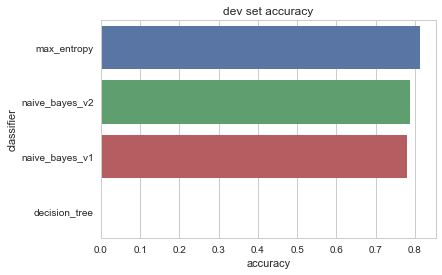

In [221]:
sns.set(style='whitegrid')
ax = sns.barplot(x='accuracy', y='classifier', 
                 data=df_dev_set_accuracy).set_title('dev set accuracy')

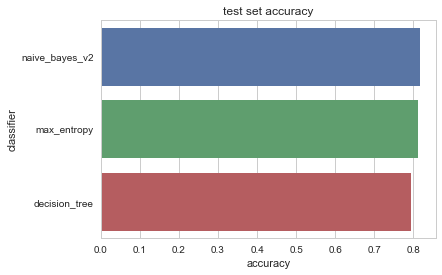

In [222]:
sns.set(style='whitegrid')
ax = sns.barplot(x='accuracy', y='classifier', 
                 data=df_test_set_accuracy).set_title('test set accuracy')

### References
http://www.nltk.org/howto/corpus.html

[Natural Language Processing with Python: Analyzing Text with the Natural Language Toolkit](https://www.amazon.com/Natural-Language-Processing-Python-Analyzing/dp/0596516495/ref=mt_paperback?_encoding=UTF8&me=&qid=)